In [1]:
import random
random.seed(42)

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
df = pd.read_csv('C:/Users/N1keFan/Desktop/mlcourse_open-master/data/ads_hour.csv',index_col=['Date'], 
                 parse_dates=['Date'])

In [3]:
df.head(3)

,ads
Date,
2017-08-03 00:00:00,49136
2017-08-03 01:00:00,46450
2017-08-03 02:00:00,46355


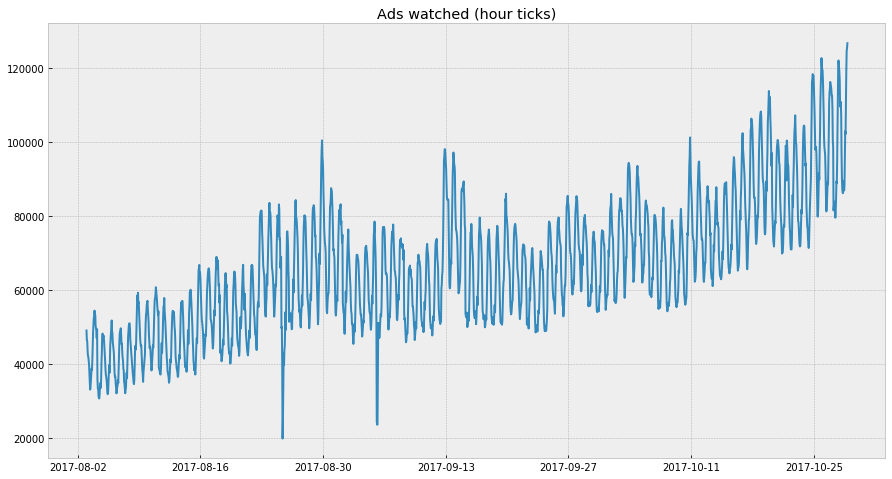

In [4]:
with plt.style.context('bmh'):    
    plt.figure(figsize=(15, 8))
    plt.title('Ads watched (hour ticks)')
    plt.plot(df.ads);

In [5]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(data, lag_start=5, lag_end=14, test_size=0.15, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data) * (1 - test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    
    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # выкидываем закодированные средними признаки 
        data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

In [6]:
# Ваш код здесь
X_train, X_test, y_train, y_test = prepareData(df, test_size=0.3, lag_start=12, lag_end=48)
st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)
X_test_scaled = st_scaler.transform(X_test)

In [7]:
%%time
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

Wall time: 438 ms


In [8]:
tscv = TimeSeriesSplit(n_splits=5)
cv_for_train_data = cross_val_score(lr, X_train_scaled, y_train,
                                    cv=tscv, scoring='neg_mean_absolute_error')
print('MAE =', (cv_for_train_data.mean() * (-1)))

MAE = 5076.31182406


1: 5076

In [9]:
def plotModelResults(model, X_train=X_train_scaled,
                            X_test=X_test_scaled,
                            plot_intervals=False):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(20, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        # Ваш код здесь
        tscv = TimeSeriesSplit(n_splits=5)
        cv = cross_val_score(model, X_test, y_test,
                             cv=tscv, scoring='neg_mean_absolute_error')

        mae = cv.mean() * (-1)
        deviation = mae.std()
        
        
        scale = 1.96
        lower = y_test.values - (mae + scale * deviation) 
        upper = y_test.values + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        
    mae  = mean_absolute_error(prediction, y_test)
    mape = mean_absolute_percentage_error(prediction, y_test)
    plt.title("MAE {}, MAPE {}%".format(round(mae), round(mape, 2)))
    plt.legend(loc="best")
    plt.grid(True);

In [10]:
def getCoefficients(model):
    """
    Возвращает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)    
    

def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    coefs = getCoefficients(model)
    
    plt.figure(figsize=(20, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

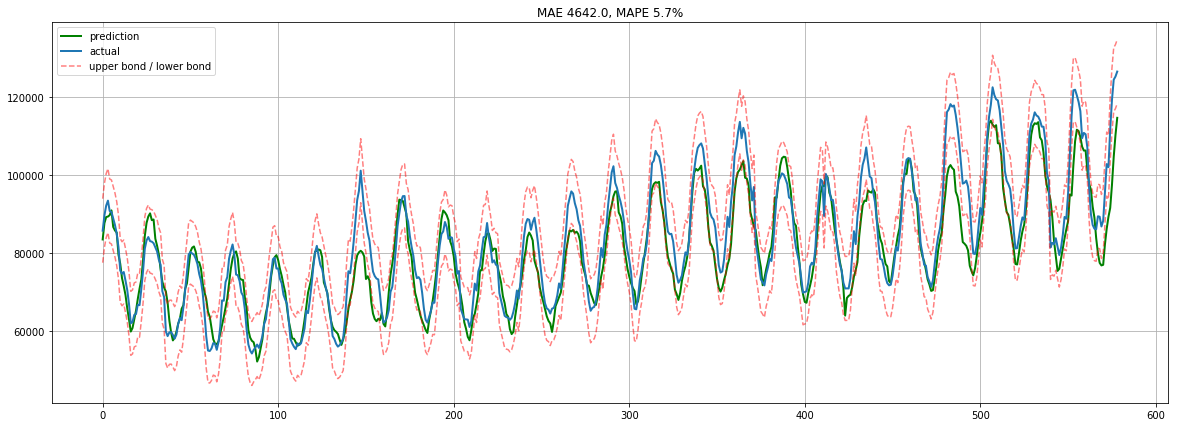

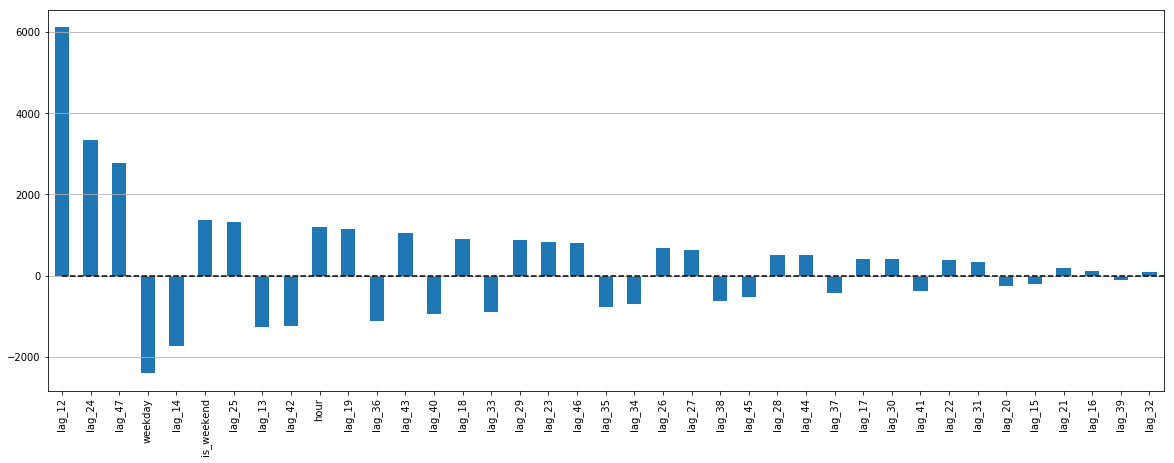

In [11]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

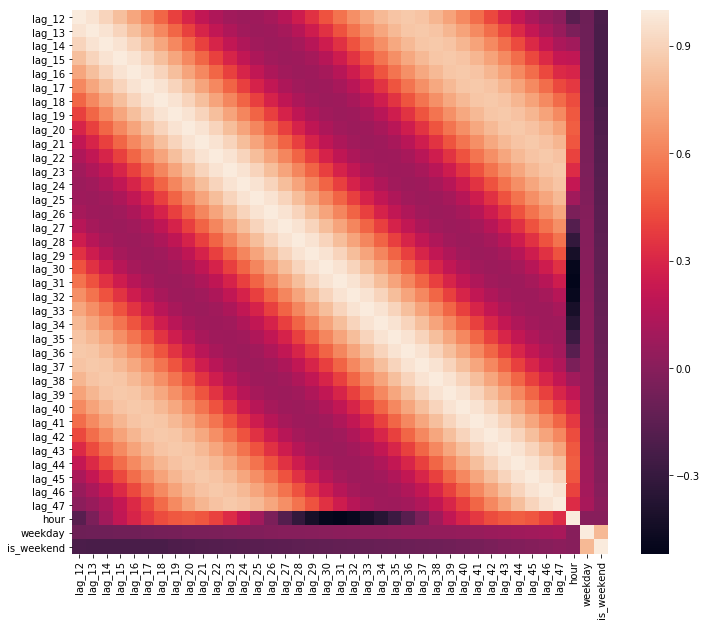

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr());

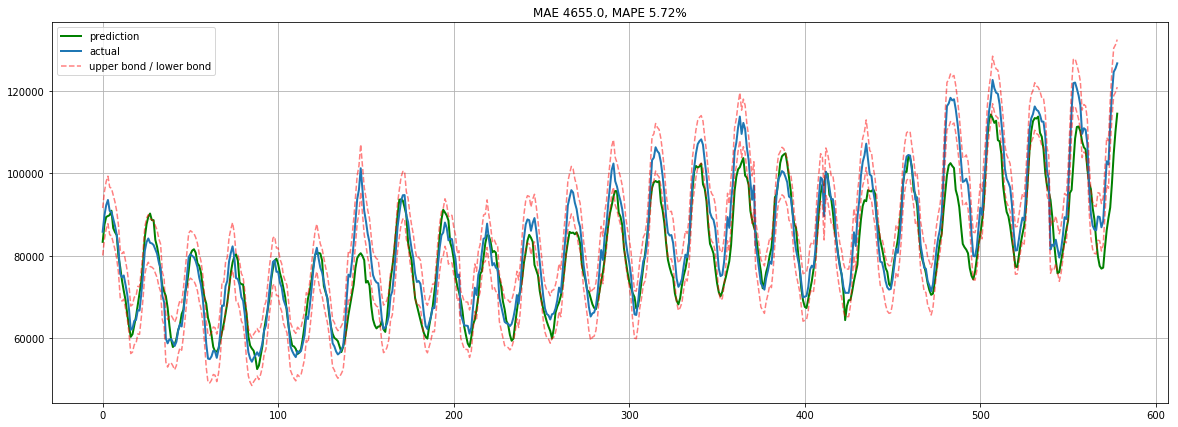

In [13]:
lasso = LassoCV(cv=tscv).fit(X_train_scaled, y_train)
plotModelResults(lasso, plot_intervals=True)

In [23]:
sum((getCoefficients(lasso).values == 0) * 1)

array([6])

2: 6

In [15]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

def plotPCA():
    """
    График накопленного процента объясненной дисперсии по компонентам
    """
    features = range(pca.n_components_)
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    plt.figure(figsize=(20, 10))
    plt.bar(features, variance)
    
    # дополнительно отметим уровень, при котором объяснены 95% дисперсии
    plt.hlines(y = 95, xmin=0, xmax=len(features), linestyles='dashed', colors='red')
    
    plt.xlabel('PCA components')
    plt.ylabel('variance')
    plt.xticks(features)
    plt.show()

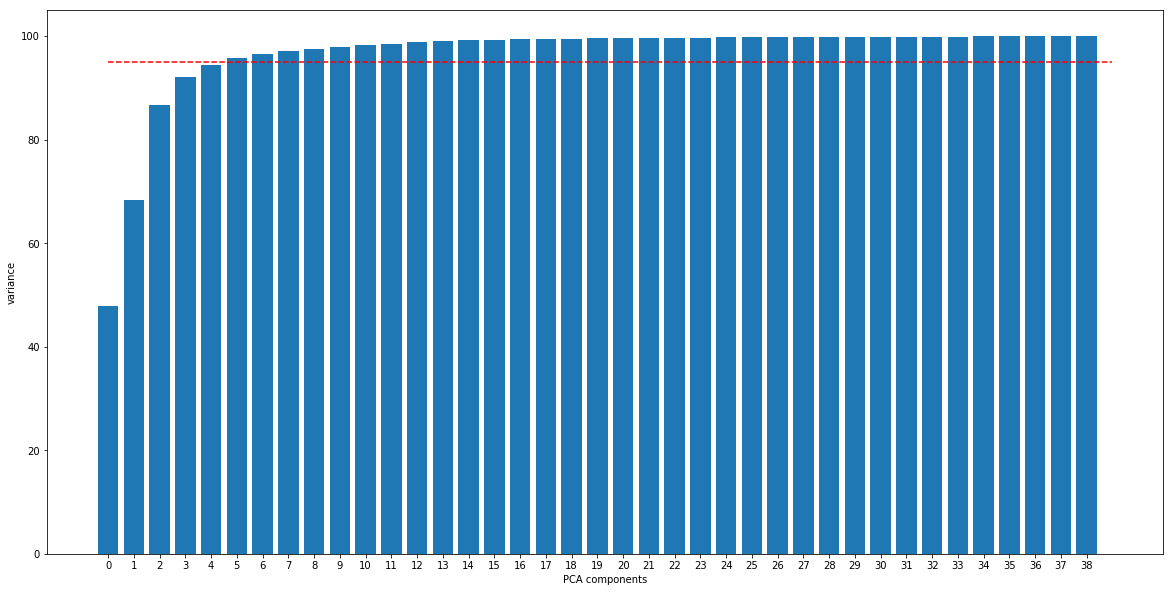

In [16]:
# Создайте объект PCA: pca
pca = PCA()

# Обучите pca на отмасштабированных данных
pca.fit(X_train_scaled, y_train)

# постройте график объясненной дисперсии
plotPCA()

3: 6

In [17]:
pca = PCA(n_components=0.95)
pca.fit(X_train_scaled, y_train)
pca_features_train = pca.transform(X_train_scaled)
pca_features_test = pca.transform(X_test_scaled)

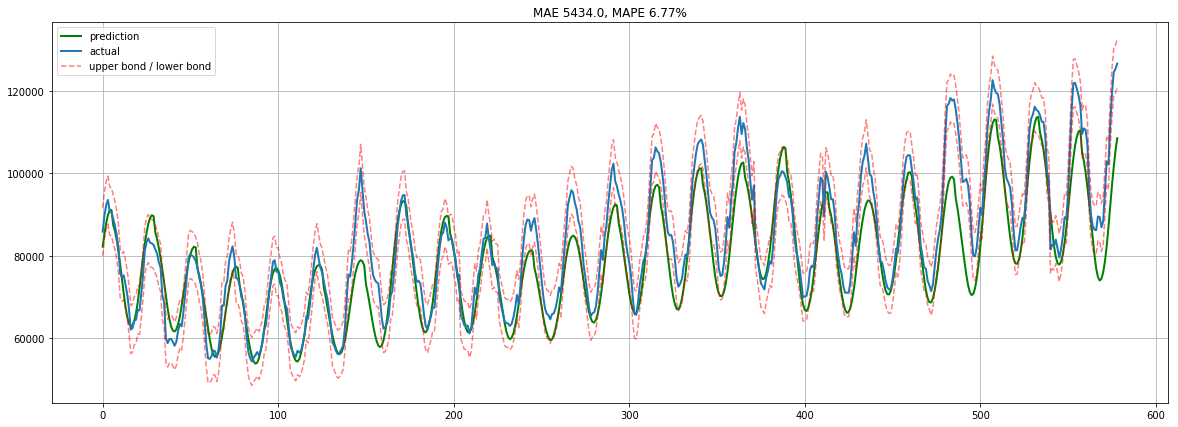

In [18]:
lr.fit(pca_features_train, y_train)
plotModelResults(lr, X_train=pca_features_train, X_test=pca_features_test, plot_intervals=True)

4: 5434